In [9]:
# pip install -U --user diffusers transformers huggingface_hub

Note: you may need to restart the kernel to use updated packages.


In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
from PIL import Image
from fastcore.all import concat
import torch, logging
from pathlib import Path
from huggingface_hub import notebook_login
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from transformers import CLIPTextModel, CLIPTokenizer
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from miniai.stability import *
logging.disable(logging.WARNING)

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

In [3]:
guidance_scale = 7.5
num_inference_steps = 50
width = height = 512

In [4]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")
# Here we use a different VAE to the original release, which has been fine-tuned for more steps
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

In [5]:
from urllib.request import urlretrieve
img_url = 'https://huggingface.co/blog/assets/98_stable_diffusion/stable_diffusion_12_1.png'
img_path = Path('horse.png')
if not img_path.exists(): urlretrieve(img_url, img_path)

In [44]:
def preprocess(image):
    w, h = image.size
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=Image.Resampling.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.0 * image - 1.0

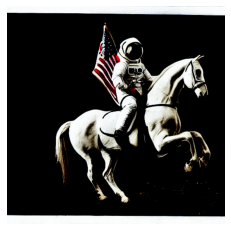

In [46]:
img = preprocess(Image.open(img_path).convert('RGB'))
show_image(img[0]);

In [146]:
def encode(x):
    latents = vae.encode(x.to("cuda", dtype=torch.float16)).latent_dist.sample()
    return latents * 0.18215

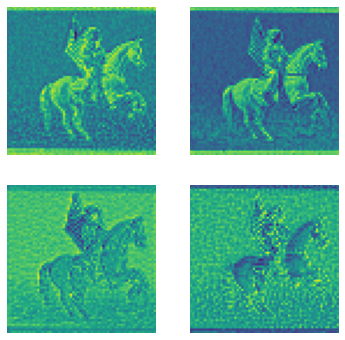

In [147]:
latents = encode(img)
show_images(latents[0].detach()); # TODO: detach in `show_images`?

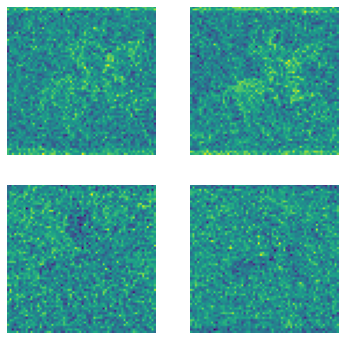

In [149]:
# TODO: try different `r`s
r = len(scheduler.timesteps)//2
timesteps = scheduler.timesteps[[r]]
noise = torch.randn_like(latents, device='cuda')
noisy_latents = scheduler.add_noise(latents, noise, timesteps)
show_images(noisey_latents[0].detach());

In [150]:
inp = scheduler.scale_model_input(torch.cat([noisy_latents] * 2), ts).cuda()

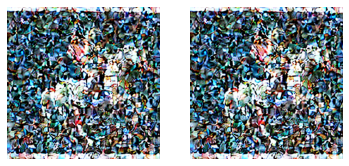

In [151]:
show_images(decode(inp).detach().to(dtype=torch.float32))

In [119]:
def embed(prompts):
    tokens = tokenizer(prompts, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    return text_encoder(tokens.input_ids.to("cuda"))[0].half()

In [132]:
prompts = ['horse', 'zebra']

In [134]:
t = embed(prompts)
u = embed([""] * len(prompts))
emb = torch.cat([u, t])
emb.shape

torch.Size([4, 77, 768])

In [135]:
torch.manual_seed(100)
g = guidance_scale
ts = timesteps

In [137]:
scheduler.set_timesteps(num_inference_steps)
with torch.no_grad(): u,t = unet(inp, ts.cuda(), encoder_hidden_states=emb.cuda()).sample.chunk(2)
pred = u + g*(t-u)
latents = scheduler.step(pred, ts, noisy_latents).prev_sample

RuntimeError: The size of tensor a (16) must match the size of tensor b (32) at non-singleton dimension 0

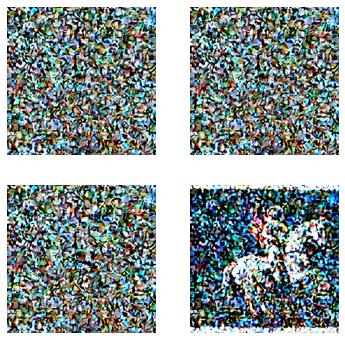

In [131]:
show_images(decode(torch.concat([u,t,pred,latents])).detach().to(dtype=torch.float32))

In [ ]:
for i,ts in enumerate(tqdm(scheduler.timesteps)):
    inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
    with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
    pred = u + g*(t-u)
    latents = scheduler.step(pred, ts, latents).prev_sample

In [80]:
def decode(x):
    with torch.no_grad(): res = vae.decode(1 / 0.18215 * x).sample
    return (res / 2 + 0.5).clamp(0, 1)

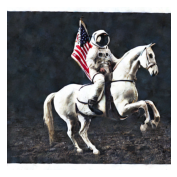

In [96]:
res = decode(latents)
show_images(res.detach().to(dtype=torch.float32));

In [155]:
def text_enc(prompts, maxlen=None):
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

def mk_img(t):
    image = (t/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray((image*255).round().astype("uint8"))

In [166]:
prompts = ['a photograph of an astronaut riding a horse']
seed = 100
steps = 50

In [167]:
bs = len(prompts)
text = text_enc(prompts)
uncond = text_enc([""] * bs, text.shape[1])
emb = torch.cat([uncond, text])
if seed: torch.manual_seed(seed)

latents = torch.randn((bs, unet.in_channels, height//8, width//8))
scheduler.set_timesteps(steps)
latents = latents.to("cuda").half() * scheduler.init_noise_sigma

for i,ts in enumerate(tqdm(scheduler.timesteps)):
    inp = scheduler.scale_model_input(latents, ts)
    with torch.no_grad(): x = unet(inp, ts, encoder_hidden_states=emb).sample
    pred = u + g*(t-u)
    latents = scheduler.step(pred, ts, latents).prev_sample

with torch.no_grad(): res = vae.decode(1 / 0.18215 * latents).sample

100%|██████████| 50/50 [00:27<00:00,  1.85it/s]


In [172]:
ts = scheduler.timesteps[0]

In [174]:
inp = scheduler.scale_model_input(latents, ts)

In [175]:
with torch.no_grad(): x = unet(inp, ts, encoder_hidden_states=emb).sample

RuntimeError: The size of tensor a (8) must match the size of tensor b (16) at non-singleton dimension 0

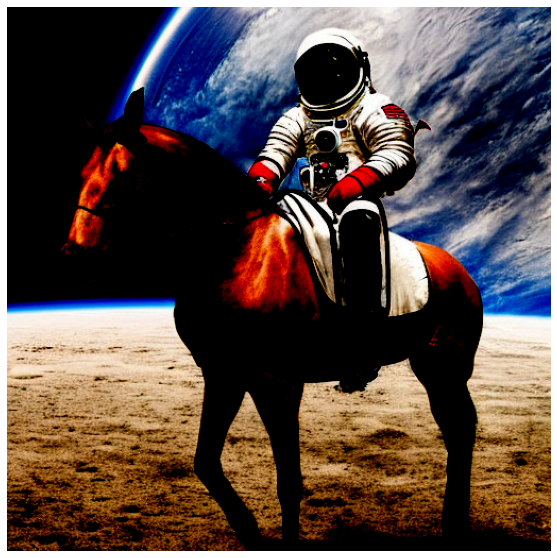

In [171]:
show_images(res.to(dtype=torch.float32), figsize=(10,10));